# Machine Learning

## What libraries should I import?

```pip install hmmlearn```

```pip install umap-learn```


In [1]:
from hmmlearn import hmm
import umap
from sklearn.mixture import GaussianMixture
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Recap
Dummy data for the following exercises is provided [here](https://ruhr-uni-bochum.sciebo.de/s/U319df4P4Lq4WJh).

In [2]:
file = '/Users/guillermo/Downloads/pose-3d.csv'
data = pd.read_csv(file, header=0)
coords = data.loc[:, ~data.columns.str.contains(
    'score|error|ncams|fnum|center|M_')]


## Helper Functions

In [3]:
def plot_prediction(data, predictions):
    """
    This function will plot the time series data and mark the transitions between predicted classes.

    """
    colors = {"0": "black", "1": "dimgray", "2": "darkgray", "3": "white", "4": "bisque", "5": "tan", "6": "orange", "7": "salmon", "8": "gold", "9": "rosybrown", "10": "beige",
              "11": "thistle", "12": "peachpuff", "13": "khaki", "14": "skyblue", "15": "lightblue", "16": "lightsteelblue", "17": "lavender", "18": "mediumaquamarine", "19": "cadetblue"}
    n = max(predictions)+1
    name = [x for x in globals() if globals()[x] is data][0]
    yloc = max(np.max(data))-(max(np.max(data)) - min(np.min(data)))/8
    locy = yloc - (max(np.max(data)) - min(np.min(data)))/8
    with plt.xkcd():
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(data)
        start_pred = 0
        for i in range(len(predictions)):
            if i == len(predictions)-1:
                end_pred = i+1
                ax.axvspan(start_pred, end_pred,
                           facecolor=colors["%d" % predictions[i]], alpha=0.5)
                loc = start_pred + (end_pred - start_pred)/2
                ax.annotate('%d' % predictions[i], xy=(loc, locy), xytext=(loc+10, yloc),
                            arrowprops=dict(arrowstyle="->", facecolor='black'))
            elif predictions[i] == predictions[i+1]:
                pass
            else:
                end_pred = i
                ax.axvspan(start_pred, end_pred,
                           facecolor=colors["%d" % predictions[i]], alpha=0.5)
                loc = start_pred + (end_pred - start_pred)/2
                ax.annotate('%d' % predictions[i], xy=(loc, locy), xytext=(loc+10, yloc),
                            arrowprops=dict(arrowstyle="->", facecolor='black'))
                start_pred = end_pred

        plt.xlabel("Time [frames]")
        plt.ylabel("Feature value from %s data" % name)
        plt.title('Model predictions with N = %d Components' % n)
        plt.show()
    return


## Time segmentation with Hidden Markov Models

In [4]:
# Now we can train a Hidden markov Model with our coordinate data
model1 = hmm.GaussianHMM(n_components=9, covariance_type="full")
model1.fit(coords)


GaussianHMM(covariance_type='full', n_components=9)

In [5]:
hmm_pred = model1.predict(coords)


In [6]:
transition1 = model1.transmat_
transition1


array([[0.97619048, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02380952, 0.        ],
       [0.        , 0.93442623, 0.01639344, 0.01639344, 0.01639344,
        0.        , 0.        , 0.        , 0.01639344],
       [0.        , 0.        , 0.97222222, 0.        , 0.        ,
        0.        , 0.02777778, 0.        , 0.        ],
       [0.        , 0.01234568, 0.        , 0.97530864, 0.        ,
        0.01234568, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01111111, 0.98888889,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.0212766 , 0.        , 0.        , 0.        ,
        0.        , 0.9787234 , 0.        , 0.        ],
       [0.        , 0.09090909, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.90909091, 0.        ],


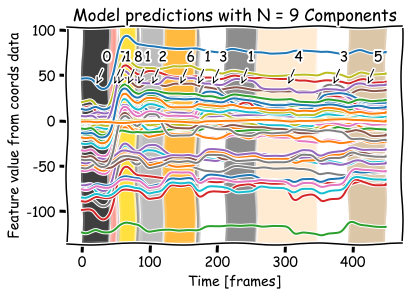

In [8]:
plot_prediction(coords, hmm_pred)


## Gaussian Mixture Model

In [9]:
gmm_pred = GaussianMixture(
    n_components=9, covariance_type='full').fit_predict(coords)


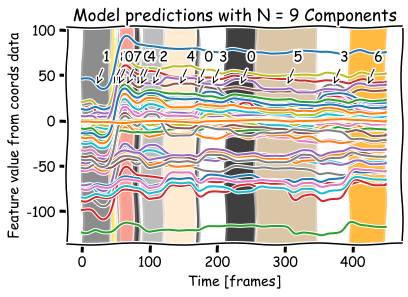

In [10]:
plot_prediction(coords, gmm_pred)


## Decision Trees

In [11]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(coords, hmm_pred)


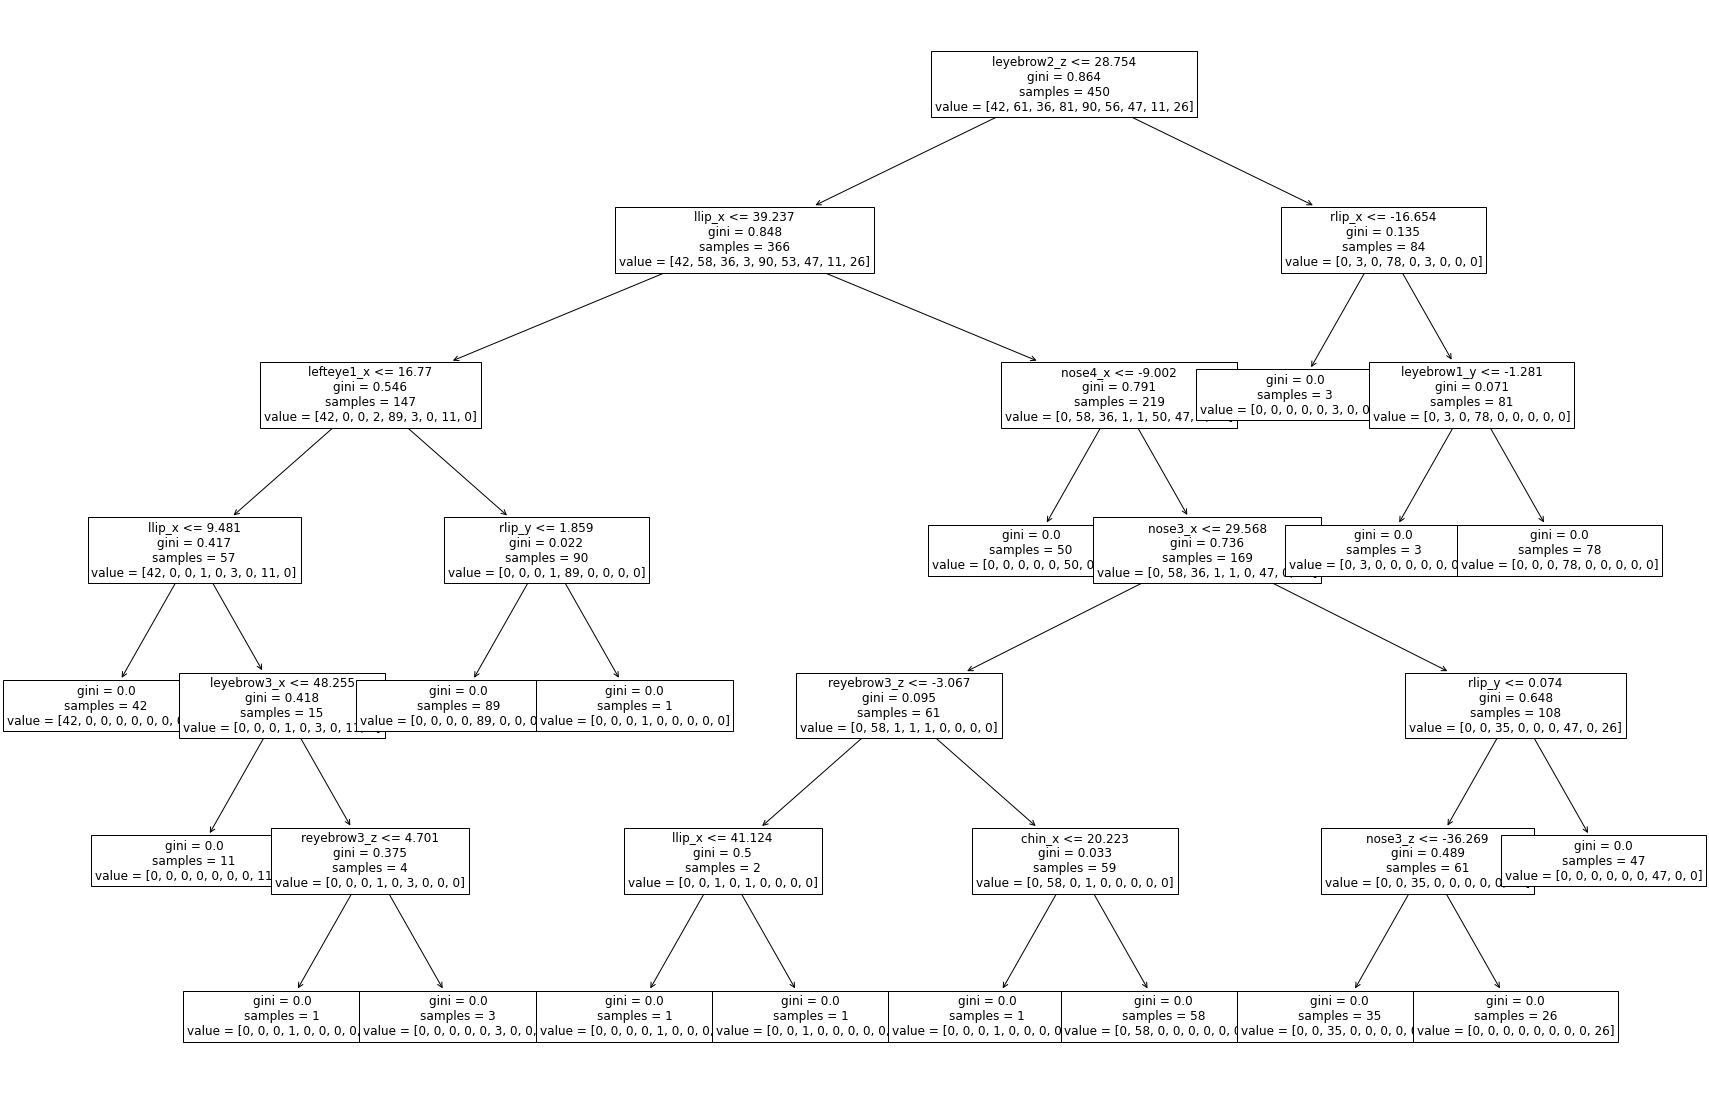

In [12]:
plt.figure(figsize=(30, 20))
tree.plot_tree(dtree, feature_names=coords.columns, fontsize=12)
plt.show()


In [13]:
n = 100
print(
    f'Prediction from decision tree for frame {n}: {dtree.predict(coords[n:n+1])}')


Prediction from decision tree for frame 100: [2]


## UMAP dimensionality reduction

In [14]:
mapper = umap.UMAP(metric='euclidean', n_neighbors=30, min_dist=0.99,
                   random_state=42, init='random').fit_transform(coords)
print(f"Umap data ready with shape {np.shape(mapper)}")


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Umap data ready with shape (450, 2)


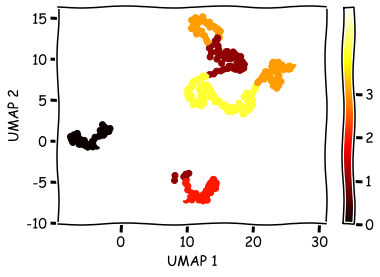

In [15]:
umap1 = mapper[:, 0]
umap2 = mapper[:, 1]
labels = hmm_pred

with plt.xkcd():
    plt.figure()
    cmap = plt.cm.get_cmap('hot')
    plt.scatter(umap1, umap2, c=labels.astype(np.float64), cmap=cmap)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar(ticks=range(4))
    plt.clim(0, 5)
    plt.show()
